In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    StratifiedKFold, StratifiedShuffleSplit,
    cross_val_predict, RandomizedSearchCV, train_test_split
)
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, balanced_accuracy_score, f1_score
)
from sklearn.multioutput import MultiOutputClassifier

from xgboost import XGBClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
USE_GPU = True  # << set False to force CPU
SUBSET_FRACTION = 0.30  # fraction of rows used for hyperparam search
N_FOLDS_OOF = 5         # for OOF evaluation (kept at 5)
CV_TUNE = 3             # folds for tuning (faster)
N_ITER_TUNE = 16        # trials in RandomizedSearch (faster)

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/train_test_data/train_encoded.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/train_test_data/test_encoded.csv")

In [ ]:
TARGETS = ["Genetic Disorder", "Disorder Subclass"]

In [ ]:
X_train = train_df.drop(columns=TARGETS)
Y_train = train_df[TARGETS].copy()
X_test  = test_df.copy()

In [ ]:
numeric_cols = X_train.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(), numeric_cols)],
    remainder="passthrough"
)

In [ ]:
def make_xgb():
    if USE_GPU:
        return XGBClassifier(
            n_estimators=800,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_alpha=0.0,
            reg_lambda=0.0,
            objective="multi:softprob",
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            gpu_id=0,
            n_jobs=1,                 # GPU path: host threads don't help much
            random_state=RANDOM_STATE,
            eval_metric="mlogloss"
        )
    else:
        return XGBClassifier(
            n_estimators=800,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_alpha=0.0,
            reg_lambda=0.0,
            objective="multi:softprob",
            tree_method="hist",
            n_jobs=-1,
            random_state=RANDOM_STATE,
            eval_metric="mlogloss"
        )

In [ ]:
base_xgb = make_xgb()

In [ ]:
cv_oof = StratifiedKFold(n_splits=N_FOLDS_OOF, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
def evaluate_target(target_name: str):
    y = Y_train[target_name]
    pipe = Pipeline([("prep", preprocessor), ("clf", base_xgb)])

    # OOF predictions & probabilities
    print(f"\n[OOF] Starting {N_FOLDS_OOF}-fold CV for target: {target_name} ...")
    y_pred_oof  = cross_val_predict(pipe, X_train, y, cv=cv_oof, method="predict", n_jobs=-1, verbose=1)
    y_proba_oof = cross_val_predict(pipe, X_train, y, cv=cv_oof, method="predict_proba", n_jobs=-1, verbose=1)

    # --- Text metrics
    print(f"\n=== {target_name} — OOF Classification Report ({N_FOLDS_OOF}-fold CV, XGBoost) ===\n")
    print(classification_report(y, y_pred_oof, digits=4, zero_division=0))

    # --- Confusion Matrix (matplotlib only)
    classes = np.unique(np.concatenate([y.unique(), y_pred_oof]))
    cm = confusion_matrix(y, y_pred_oof, labels=classes)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(classes)),
        yticks=np.arange(len(classes)),
        xticklabels=classes,
        yticklabels=classes,
        ylabel="True label",
        xlabel="Predicted label",
        title=f"Confusion Matrix — {target_name} (OOF, XGBoost)"
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

    # --- ROC (OvR) from OOF probabilities
    if y_proba_oof is not None and y_proba_oof.ndim == 2 and y_proba_oof.shape[1] >= 2:
        # Fit once to get class order (legend only)
        pipe.fit(X_train, y)
        cls_order = pipe.named_steps["clf"].classes_

        fig = plt.figure(figsize=(7, 5))
        for k, cls in enumerate(cls_order):
            fpr, tpr, _ = roc_curve((y == cls).astype(int), y_proba_oof[:, k])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, linewidth=2, label=f"{cls} (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curves (OvR) — {target_name} (OOF, XGBoost)")
        plt.legend()
        plt.show()


[OOF] Starting 5-fold CV for target: Genetic Disorder ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.7s finished



=== Genetic Disorder — OOF Classification Report (5-fold CV, XGBoost) ===

              precision    recall  f1-score   support

           0     0.6386    0.7598    0.6939      9241
           1     0.4391    0.3015    0.3575      1877
           2     0.5343    0.4444    0.4852      6929

    accuracy                         0.5910     18047
   macro avg     0.5373    0.5019    0.5122     18047
weighted avg     0.5778    0.5910    0.5788     18047



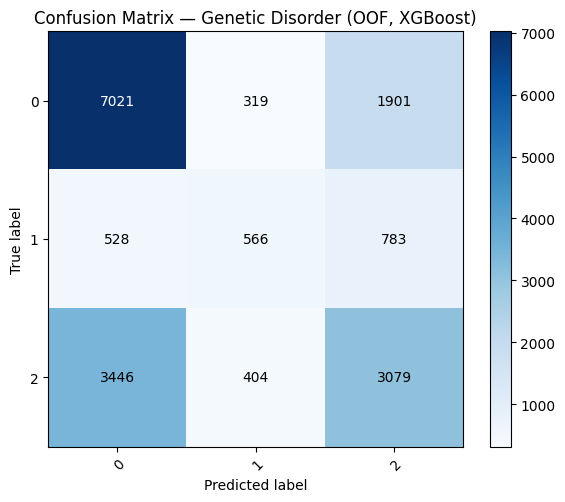

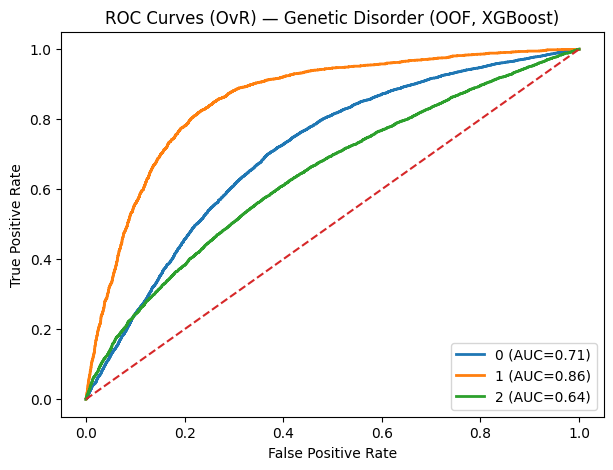


[OOF] Starting 5-fold CV for target: Disorder Subclass ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished



=== Disorder Subclass — OOF Classification Report (5-fold CV, XGBoost) ===

              precision    recall  f1-score   support

           0     0.2778    0.0752    0.1183       133
           1     0.3333    0.0769    0.1250        91
           2     0.4472    0.4944    0.4696      3145
           3     0.3709    0.2589    0.3050      1653
           4     0.3644    0.2419    0.2907      1228
           5     0.3213    0.1363    0.1914       587
           6     0.4093    0.4931    0.4473      4683
           7     0.3464    0.3742    0.3598      3971
           8     0.3322    0.3071    0.3192      2556

    accuracy                         0.3855     18047
   macro avg     0.3559    0.2731    0.2918     18047
weighted avg     0.3803    0.3855    0.3777     18047



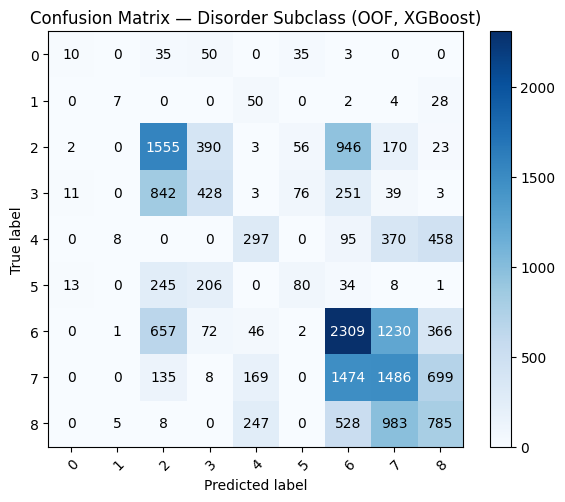

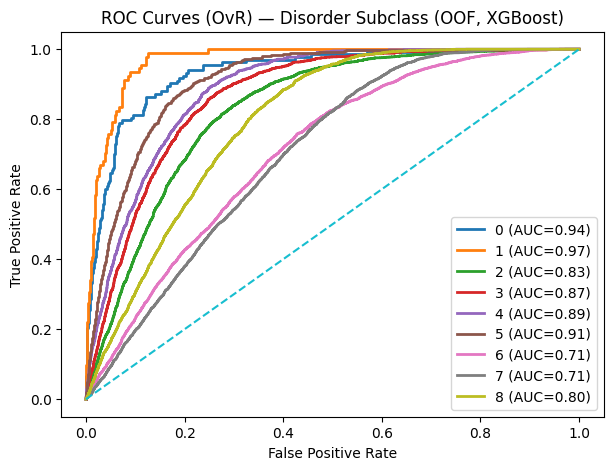

In [ ]:
for tgt in TARGETS:
    evaluate_target(tgt)

In [ ]:
per_target_rows = []
for tgt in TARGETS:
    y = Y_train[tgt]
    pipe = Pipeline([("prep", preprocessor), ("clf", base_xgb)])
    print(f"\n[OOF] Computing summary metrics for {tgt} ...")
    y_pred_oof = cross_val_predict(pipe, X_train, y, cv=cv_oof, method="predict", n_jobs=-1, verbose=1)

    acc  = accuracy_score(y, y_pred_oof)
    bacc = balanced_accuracy_score(y, y_pred_oof)
    f1m  = f1_score(y, y_pred_oof, average="macro", zero_division=0)
    f1w  = f1_score(y, y_pred_oof, average="weighted", zero_division=0)
    per_target_rows.append({"target": tgt, "accuracy": acc, "balanced_accuracy": bacc, "f1_macro": f1m, "f1_weighted": f1w})


[OOF] Computing summary metrics for Genetic Disorder ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



[OOF] Computing summary metrics for Disorder Subclass ...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


In [ ]:
summary_df = pd.DataFrame(per_target_rows).round(4)
print("\nOOF summary per target (XGBoost base):")
print(summary_df.to_string(index=False))


OOF summary per target (XGBoost base):
           target  accuracy  balanced_accuracy  f1_macro  f1_weighted
 Genetic Disorder    0.5910             0.5019    0.5122       0.5788
Disorder Subclass    0.3855             0.2731    0.2918       0.3777


In [ ]:
mean_acc = float(np.mean(summary_df["accuracy"]))
print("\nOverall mean accuracy (OOF across targets): {:.4f}".format(mean_acc))


Overall mean accuracy (OOF across targets): 0.4882


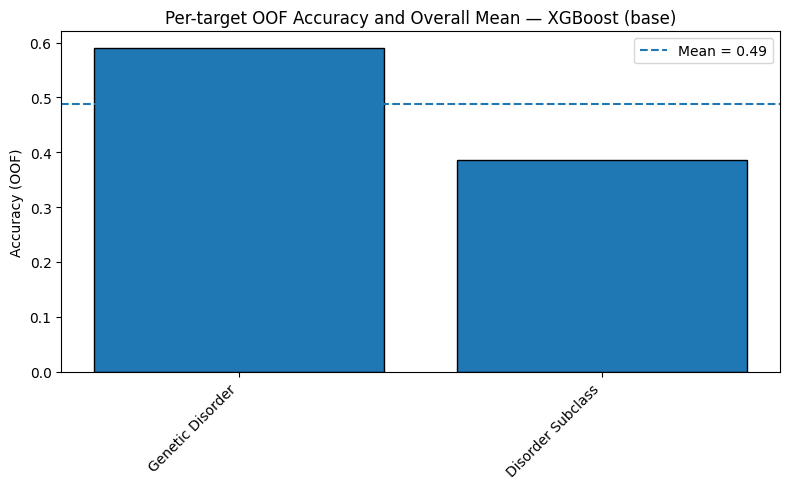

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(summary_df["target"], summary_df["accuracy"], edgecolor="black")
plt.axhline(mean_acc, linestyle="--", label=f"Mean = {mean_acc:.2f}")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy (OOF)")
plt.title("Per-target OOF Accuracy and Overall Mean — XGBoost (base)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
y_primary = Y_train["Genetic Disorder"]

# subset indices for faster search
sss = StratifiedShuffleSplit(n_splits=1, test_size=SUBSET_FRACTION, random_state=RANDOM_STATE)
sub_ix, _ = next(sss.split(X_train, y_primary))
X_tune, y_tune = X_train.iloc[sub_ix], y_primary.iloc[sub_ix]

In [ ]:
def make_tune_xgb():
    if USE_GPU:
        return XGBClassifier(
            objective="multi:softprob",
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            gpu_id=0,
            n_jobs=1,
            random_state=RANDOM_STATE,
            eval_metric="mlogloss"
        )
    else:
        return XGBClassifier(
            objective="multi:softprob",
            tree_method="hist",
            n_jobs=-1,
            random_state=RANDOM_STATE,
            eval_metric="mlogloss"
        )

In [ ]:
pipe_gs = Pipeline([
    ("prep", preprocessor),
    ("clf", make_tune_xgb())
])

In [ ]:
param_dist = {
    "clf__n_estimators":        [400, 600, 800, 1000],
    "clf__max_depth":           [4, 6, 8],
    "clf__learning_rate":       [0.03, 0.05, 0.1],
    "clf__subsample":           [0.7, 0.9, 1.0],
    "clf__colsample_bytree":    [0.7, 0.9, 1.0],
    "clf__reg_alpha":           [0.0, 0.1, 0.5],
    "clf__reg_lambda":          [0.0, 0.1, 0.5],
}

In [ ]:
print(f"\n[FAST TUNING] RandomizedSearchCV on subset ({len(X_tune)} rows), "
      f"n_iter={N_ITER_TUNE}, cv={CV_TUNE}, verbose=2 ...")


[FAST TUNING] RandomizedSearchCV on subset (12632 rows), n_iter=16, cv=3, verbose=2 ...


In [ ]:
fast_gs = RandomizedSearchCV(
    estimator=pipe_gs,
    param_distributions=param_dist,
    n_iter=N_ITER_TUNE,
    scoring="f1_macro",
    cv=CV_TUNE,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2,     # << verbose enabled
    refit=True
)

In [ ]:
fast_gs.fit(X_tune, y_tune)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Gender_ambiguous',
                                                                                'Gender_female',
                                                                                'Gender_male',
                                                                                'Blood '
                                                                                'test '
                                                                                'result_abnormal',
                                                                                'Blood '
                                                                                'test '
                                                                                'result_inconclusive',
                                                                                'Blood '
                                                                                'test '
                                                                                'result_normal',
                                                                                'Blood '
                                                                                'test '
                                                                                'result_slightly '
                                                                                'abnormal',
                                                                                'Patient '
                                                                                'Age',
                                                                                'Blood '
                                                                                'cel...
                                                            n_estimators=None,
                                                            n_jobs=1, ...))]),
                   n_iter=16, n_jobs=-1,
                   param_distributions={'clf__colsample_bytree': [0.7, 0.9,
                                                                  1.0],
                                        'clf__learning_rate': [0.03, 0.05, 0.1],
                                        'clf__max_depth': [4, 6, 8],
                                        'clf__n_estimators': [400, 600, 800,
                                                              1000],
                                        'clf__reg_alpha': [0.0, 0.1, 0.5],
                                        'clf__reg_lambda': [0.0, 0.1, 0.5],
                                        'clf__subsample': [0.7, 0.9, 1.0]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [ ]:
print("\nFAST best params:", fast_gs.best_params_)
print("FAST best CV macro-F1:", round(fast_gs.best_score_, 4))


FAST best params: {'clf__subsample': 0.9, 'clf__reg_lambda': 0.1, 'clf__reg_alpha': 0.5, 'clf__n_estimators': 400, 'clf__max_depth': 6, 'clf__learning_rate': 0.03, 'clf__colsample_bytree': 0.7}
FAST best CV macro-F1: 0.5102


In [ ]:
best = fast_gs.best_params_

In [ ]:
def make_best_xgb(best_params):
    # extract tuned params (they are prefixed with 'clf__')
    n_estimators     = best_params["clf__n_estimators"]
    max_depth        = best_params["clf__max_depth"]
    learning_rate    = best_params["clf__learning_rate"]
    subsample        = best_params["clf__subsample"]
    colsample_bytree = best_params["clf__colsample_bytree"]
    reg_alpha        = best_params["clf__reg_alpha"]
    reg_lambda       = best_params["clf__reg_lambda"]

    if USE_GPU:
        return XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            objective="multi:softprob",
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            gpu_id=0,
            n_jobs=1,
            random_state=RANDOM_STATE,
            eval_metric="mlogloss"
        )
    else:
        return XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            objective="multi:softprob",
            tree_method="hist",
            n_jobs=-1,
            random_state=RANDOM_STATE,
            eval_metric="mlogloss"
        )


In [ ]:
best_xgb = make_best_xgb(best)

In [ ]:
print("\n[FINAL FIT] Fitting MultiOutputClassifier with tuned XGBoost on ALL training data ...")
X_train_t = preprocessor.fit_transform(X_train)
if USE_GPU:
    # XGBoost on GPU benefits from float32
    X_train_t = X_train_t.astype(np.float32)


[FINAL FIT] Fitting MultiOutputClassifier with tuned XGBoost on ALL training data ...


In [ ]:
multi_xgb = MultiOutputClassifier(best_xgb)
multi_xgb.fit(X_train_t, Y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              gpu_id=0, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.03, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=400, n_jobs=1, ...))

In [ ]:
X_test_t = preprocessor.transform(X_test)
if USE_GPU:
    X_test_t = X_test_t.astype(np.float32)

In [ ]:
Y_test_pred = multi_xgb.predict(X_test_t)           # shape: (n_test, len(TARGETS))
proba_list  = multi_xgb.predict_proba(X_test_t)

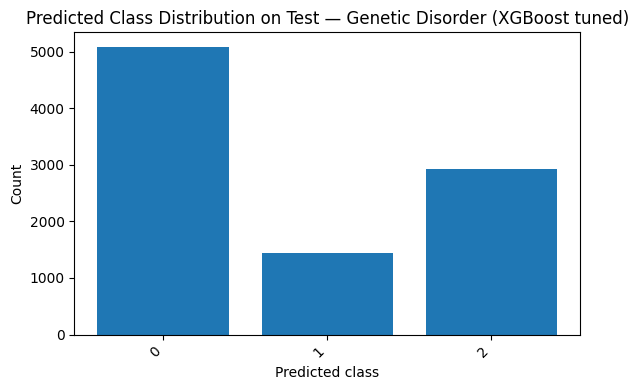

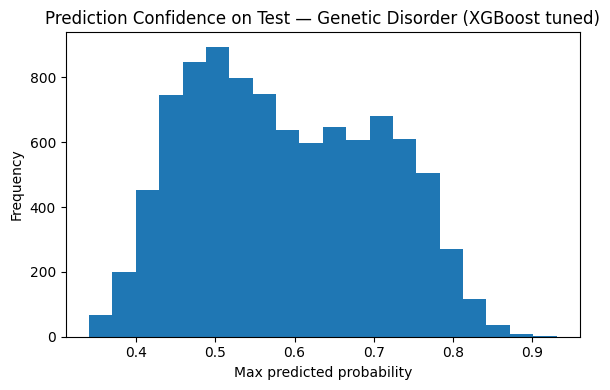

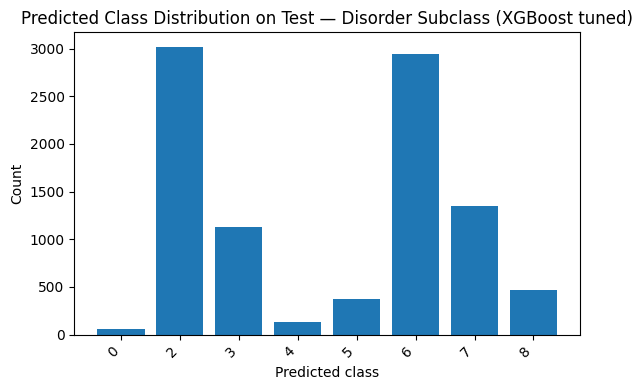

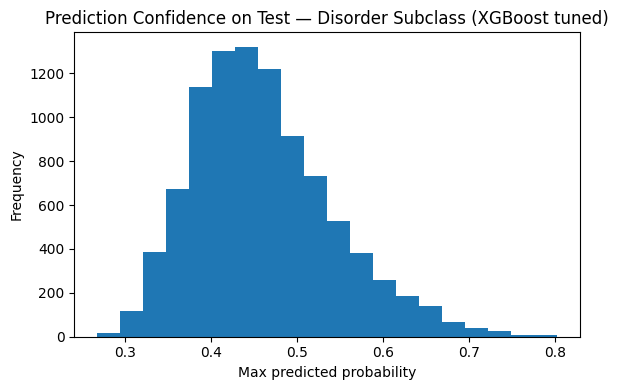

In [ ]:
for t, target in enumerate(TARGETS):
    y_pred_t = Y_test_pred[:, t].astype(str)

    # (a) Predicted class distribution
    fig = plt.figure(figsize=(6, 4))
    uniq, cnts = np.unique(y_pred_t, return_counts=True)
    order = np.argsort(uniq.astype(str))
    uniq, cnts = uniq[order], cnts[order]
    plt.bar(uniq.astype(str), cnts)
    plt.xlabel("Predicted class")
    plt.ylabel("Count")
    plt.title(f"Predicted Class Distribution on Test — {target} (XGBoost tuned)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # (b) Confidence histogram (max probability)
    if proba_list is not None and len(proba_list) > t and proba_list[t] is not None:
        max_conf = proba_list[t].max(axis=1)
        fig = plt.figure(figsize=(6, 4))
        plt.hist(max_conf, bins=20)
        plt.xlabel("Max predicted probability")
        plt.ylabel("Frequency")
        plt.title(f"Prediction Confidence on Test — {target} (XGBoost tuned)")
        plt.tight_layout()
        plt.show()